In [1]:
############### LOADING DATA ###############

%run '/home/christianl/Zhang-Lab/Zhang Lab Code/Boilerplate_datahandling/Remote boilerplate/model_load.py'

Loading pre-computed predictions...
✓ Loaded predictions for 3 models
  Training samples: 12748, Genes: 16100
  Test samples: 3187, Genes: 16100
  Val samples: 262, Genes: 16100

✓ All functions loaded. Ready for analysis!


In [7]:
############### UNIT TEST ###############

# Check what your y_validation columns actually are:
print("y_validation columns type:", type(y_validation.columns))
print("First 5 column names:", y_validation.columns[:5].tolist())

# Also check if y_validation is actually a DataFrame or numpy array:
print("y_validation type:", type(y_validation))

y_validation columns type: <class 'pandas.core.indexes.base.Index'>
First 5 column names: ['A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'AAAS']
y_validation type: <class 'pandas.core.frame.DataFrame'>


In [2]:
############### PLOTTING FUNCTION ###############

def figure_3_observed_vs_predicted_external(y_true, predictions_dict, 
                                  r2_method='variance_weighted',
                                  output_path='~/Zhang-Lab/Zhang Lab Data/Saved figures/'):
    """
    Generate observed vs. predicted scatterplot with Pearson correlation, R2, RMSE and MAE.
    """
    set_publication_style()
    fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_TRIPLE)
    model_names = list(predictions_dict.keys())
    
    for idx, model_name in enumerate(model_names):
        ax = axes[idx]
        y_pred = predictions_dict[model_name]
        
        # Flatten arrays for scatter plot
        y_true_flat = np.asarray(y_true).ravel()
        y_pred_flat = np.asarray(y_pred).ravel()
        
        # Compute metrics based on specified method
        if r2_method == 'variance_weighted' or r2_method == 'flattened':
            r2 = r2_score(y_true_flat, y_pred_flat)
            r2_label = "R² (var-w)" # Shortened for display fit
        elif r2_method == 'uniform_average':
            r2 = r2_score(y_true, y_pred, multioutput='uniform_average')
            r2_label = "R² (uni-avg)"
        else:
            raise ValueError(f"Unknown r2_method: {r2_method}")
        
        # Pearson correlation
        pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)

        # --- NEW: Calculate RMSE and MAE for the plot ---
        rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        
        # Scatter plot
        ax.scatter(y_true_flat, y_pred_flat, alpha=0.5, s=5, 
                   color=MODEL_COLORS.get(model_name, '#1f77b4'),
                   edgecolors='none')
        
        # Perfect prediction diagonal line
        min_val = min(y_true_flat.min(), y_pred_flat.min())
        max_val = max(y_true_flat.max(), y_pred_flat.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', 
                lw=1, alpha=0.5, label='Perfect prediction')
        
        # Fit regression line
        z = np.polyfit(y_true_flat, y_pred_flat, 1)
        p = np.poly1d(z)
        x_line = np.linspace(y_true_flat.min(), y_true_flat.max(), 100)
        y_line = p(x_line)
        ax.plot(x_line, y_line, color="#000000",
                lw=1.5, alpha=0.8, label='Linear fit')
        
        # Labels and formatting
        ax.set_xlabel('Observed Expression (Log10)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Predicted Expression (Log10)', fontsize=12, fontweight='bold')
        ax.set_title(model_name, fontsize=13, fontweight='bold')
        
        # --- MODIFIED: Add RMSE and MAE to text box ---
        # Construct the string part by part for clarity
        stats_text = (f"Pearson's R = {pearson_r:.4f}\n"
                      f"{r2_label} = {r2:.4f}\n"
                      f"RMSE = {rmse:.4f}\n"
                      f"MAE = {mae:.4f}")
        
        # Append p-value logic
        if p_value < 0.001:
            textstr = f"{stats_text}\np < 0.001"
        else:
            textstr = f"{stats_text}\np = {p_value:.3f}"
        
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)
    
    # counting how many points are within visible range
    for idx, model_name in enumerate(model_names):
        ax = axes[idx]
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
    
        y_pred = predictions_dict[model_name]
        y_true_flat = np.asarray(y_true).ravel()
        y_pred_flat = np.asarray(y_pred).ravel()
    
        outside_x = ((y_true_flat < xlim[0]) | (y_true_flat > xlim[1])).sum()
        outside_y = ((y_pred_flat < ylim[0]) | (y_pred_flat > ylim[1])).sum()
        
        print(f"\n{model_name}:")
        print(f"  Axis limits: x={xlim}, y={ylim}")
        print(f"  Points outside x-range: {outside_x}")
        print(f"  Points outside y-range: {outside_y}")
        print(f"  Data range: x=[{y_true_flat.min():.2f}, {y_true_flat.max():.2f}], y=[{y_pred_flat.min():.2f}, {y_pred_flat.max():.2f}]")
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
    print(f"Figure 1 saved to {output_path}")
    plt.show()
    
    # Return metrics for reference
    metrics_summary = {}
    for model_name in model_names:
        y_pred = predictions_dict[model_name]
        y_true_flat = np.asarray(y_true).ravel()
        y_pred_flat = np.asarray(y_pred).ravel()
        
        pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
        r2_variance_weighted = r2_score(y_true_flat, y_pred_flat)
        r2_uniform = r2_score(y_true, y_pred, multioutput='uniform_average')
        rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
        mae = mean_absolute_error(y_true_flat, y_pred_flat)
        
        metrics_summary[model_name] = {
            'pearson_r': pearson_r,
            'p_value': p_value,
            'r2_variance_weighted': r2_variance_weighted,
            'r2_uniform_average': r2_uniform,
            'rmse': rmse,
            'mae': mae
        }
    
    return metrics_summary

In [10]:
############### UNIT TEST ###############

# How many MLR predictions are in the "visible" range of your plot (roughly 0-7)?
visible_range = (mlr_y_pred_val >= -1) & (mlr_y_pred_val <= 7)
print(f"MLR predictions in visible range: {visible_range.sum()} / {mlr_y_pred_val.size}")
print(f"Percentage visible: {100 * visible_range.sum() / mlr_y_pred_val.size:.2f}%")

MLR predictions in visible range: 4218184 / 4218200
Percentage visible: 100.00%


In [11]:
############### UNIT TEST ###############

print("Prediction variance:")
for model_name, y_pred in predictions_validation.items():
    print(f"{model_name}: {y_pred.std():.4f}")

Prediction variance:
MLR: 0.5760
XGBRFRegressor: 0.5586
RNN: 0.5187



MLR:
  Axis limits: x=(np.float64(0.0), np.float64(6.0)), y=(np.float64(0.0), np.float64(6.0))
  Points outside x-range: 0
  Points outside y-range: 375951
  Data range: x=[0.00, 4.96], y=[-1.46, 5.17]

XGBRFRegressor:
  Axis limits: x=(np.float64(0.0), np.float64(6.0)), y=(np.float64(0.0), np.float64(6.0))
  Points outside x-range: 0
  Points outside y-range: 0
  Data range: x=[0.00, 4.96], y=[0.00, 4.85]

RNN:
  Axis limits: x=(np.float64(0.0), np.float64(6.0)), y=(np.float64(0.0), np.float64(6.0))
  Points outside x-range: 0
  Points outside y-range: 347646
  Data range: x=[0.00, 4.96], y=[-0.30, 4.51]
Figure 1 saved to /home/christianl/Zhang-Lab/Zhang Lab Data/Saved figures/Production_model_figures(x_validation)/figure3external_(smaller view.v1)).png


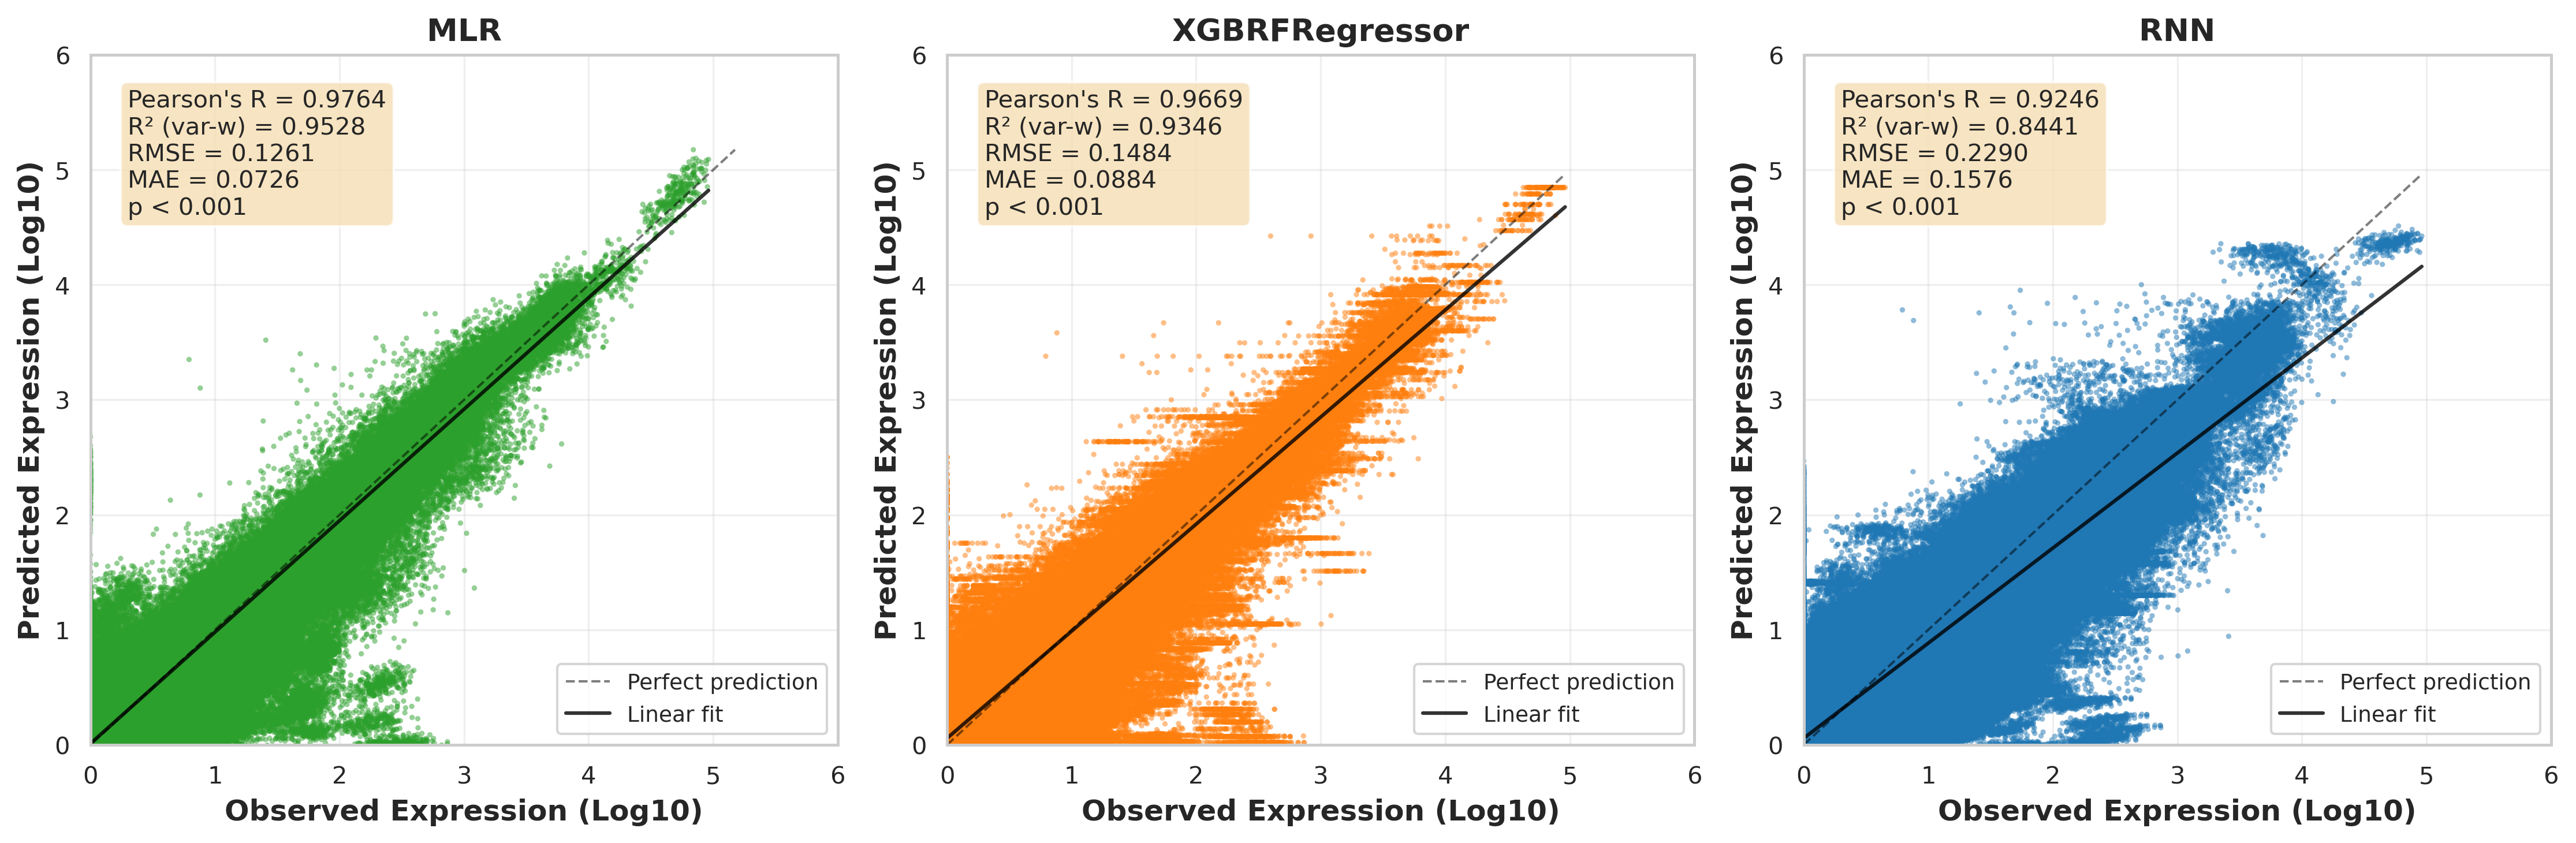

{'MLR': {'pearson_r': np.float64(0.9763834166139626),
  'p_value': np.float64(0.0),
  'r2_variance_weighted': 0.952761344149564,
  'r2_uniform_average': -111.02945924048763,
  'rmse': np.float64(0.12608623480002995),
  'mae': 0.07262095578287969},
 'XGBRFRegressor': {'pearson_r': np.float64(0.9669336170939931),
  'p_value': np.float64(0.0),
  'r2_variance_weighted': 0.9345554127123676,
  'r2_uniform_average': -54.35562515258789,
  'rmse': np.float64(0.148407475265123),
  'mae': 0.08844870745453155},
 'RNN': {'pearson_r': np.float64(0.9246409304383578),
  'p_value': np.float64(0.0),
  'r2_variance_weighted': 0.8441254195241787,
  'r2_uniform_average': -449.6048583984375,
  'rmse': np.float64(0.22903748123447745),
  'mae': 0.1576187647712257}}

In [3]:
############### PLOTTING STEP ###############

figure_3_observed_vs_predicted_external(y_validation,predictions_validation,r2_method='variance_weighted', output_path = '/home/christianl/Zhang-Lab/Zhang Lab Data/Saved figures/Production_model_figures(x_validation)/figure3external_(smaller view.v1)).png')